# **Titanic: Machine Learning from Disaster**

Name: Neta Ben Mordechai  
Name: Itay Chabra

Link to Kaggle: https://www.kaggle.com/netabenmordechai 

---

## **Overview**  
This assignment focuses on building predictive models to determine the survival of passengers on the Titanic using various machine learning techniques, including K-Nearest Neighbors (KNN), Linear Discriminant Analysis (LDA), and Naive Bayes Classifier (NBC). The project involves preprocessing the data (handling missing values and adding a small constant to prevent zero variance), performing feature selection (using forward selection), and applying bootstrap bagging for model training.  

The models' performance is evaluated using Out-Of-Bag (OOB) validation, and key metrics such as accuracy, precision, recall, and F1 score are calculated.  
The goal is to build reliable and accurate predictive models for the Titanic passengers' survival, providing insights into the importance of different features and the models' behavior.

---

### Imports

In [5]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, log_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Data Investigation and Preprocessing  

---

Import train and test datasets

In [8]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
print ("Train: ",train.shape[0],"passengers, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"passengers, and ",test.shape[1],"features")

Train:  891 passengers, and  12 features
Test:  418 passengers, and  11 features


### **Explanation of the Features:**
We have 12 columns; 11 features and 1 lable

**Data Dictionary**

| Variable | Definition | Key | Type
| :-: | :-: | :-: | :-:
| Survived | Survival | 0 = No, 1 = Yes | int 
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd | int
| Sex | Sex | | string
| Age | Age in years | | float
| SibSp | # of siblings / spouses aboard the Titanic | | int
| Parch | # of parents / children aboard the Titanic | | int
| Ticket | 	Ticket number | | string
| Fare | Passenger fare | | float
| Cabin | Cabin number | | string
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | string


*The Target:*

* `Survived` - (0 = No, 1 = Yes)

Our features are devided to 3 types:
*  **categorical** (`Sex`, `Embarked` and the target `Survived`):

Categorical features are features that has no intrinsic order between their values (survived, not-survived).   

* **ordinal** (`SibSp`, `Parch`, `Pclass`):

Ordinal features have order between values (1 child, 2 childs, etc.).

* **Numerical** (`Age`, `Fare`).

Numerical features are features that unlike ordinal features, there is a meaning to the values in between  

---

We can drop the Id colum since it's unnecessary for the prediction process

In [14]:
train_ID = train['PassengerId']
test_ID = test['PassengerId']

train.drop("PassengerId", axis = 1, inplace = True)
test.drop("PassengerId", axis = 1, inplace = True)

## Feature Engineering
* Extract title from `Name` to create a new feature named Title
* Combine `SibSp` and `Parch` to a new feature named FamilyCount

---

In [16]:
def extract_titles(df):
    df['Title'] = df['Name'].str.extract(', ([A-Za-z]+).', expand=False)

def change_to_common_title(df):
    common = ['Master', 'Mr', 'Miss', 'Mrs']
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = [x if x in common else 'Rare' for x in df['Title']]

extract_titles(train)
extract_titles(test)

change_to_common_title(train)
change_to_common_title(test)

In [17]:
def create_family_feature(df):
    df['FamilyCount'] = df['SibSp'] + df['Parch'] + 1

create_family_feature(train)
create_family_feature(test)

- We extracted titles from `Name` and there is no need for this feature anymore
- `SibSp` and `Parch` where combined to the a column `FamilyCount`

In [19]:
train.drop(['Name', 'SibSp', 'Parch'], axis = 1, inplace = True)
test.drop(['Name', 'SibSp', 'Parch'], axis = 1, inplace = True)

In [20]:
print("Train Data:")
train.head()

Train Data:


,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilyCount
0,0,3,male,22.0,A/5 21171,7.2500,NaN,S,Mr,2
1,1,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,2
2,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,1,1,female,35.0,113803,53.1000,C123,S,Mrs,2
4,0,3,male,35.0,373450,8.0500,NaN,S,Mr,1


## Encoding the data  - `Title`, `Sex`

---

### One-Hot Encode Categorical Features
In order to fill in the missing values and also train the machine we need to encode the categorical features in our Dataset.

Our Dataset includes both numeric and catagorical features. To handle this we need to preprocess the dataset to convert the catagorical features into a numeric format. We will use one-hot encoding for this task

we will do this with the get_dummies() function in Panda

In [23]:
# Convert the 'Title' column to string or category type
train['Title'] = train['Title'].astype(str)
test['Title'] = test['Title'].astype(str)

# One-hot encode the 'Title' feature
train_title_dummies = pd.get_dummies(train['Title'], prefix='Title', dtype=int)
test_title_dummies = pd.get_dummies(test['Title'], prefix='Title', dtype=int)

# Align the columns for train and test datasets
train_title_dummies, test_title_dummies = train_title_dummies.align(test_title_dummies, fill_value=0, axis=1)

# Add the encoded columns to the original DataFrame
train = pd.concat([train, train_title_dummies], axis=1).drop(columns=['Title'])
test = pd.concat([test, test_title_dummies], axis=1).drop(columns=['Title'])

In [24]:
# Selecting the `sex` column from train and test
train_sex = train[['Sex']]
test_sex = test[['Sex']]

# Initialize the OneHotEncoder
enc = OneHotEncoder(drop='first', sparse_output=False)  # Drop the first category (e.g., "Male" or "Female")

# Fit on the train data
enc.fit(train_sex)

# Transform train and test data
train_sex_enc = pd.DataFrame(enc.transform(train_sex), columns=enc.get_feature_names_out(['Sex']), index=train.index)
test_sex_enc = pd.DataFrame(enc.transform(test_sex), columns=enc.get_feature_names_out(['Sex']), index=test.index)

# Drop original `sex` column and concatenate encoded features
train = train.drop(columns=['Sex']).join(train_sex_enc)
test = test.drop(columns=['Sex']).join(test_sex_enc)

In [25]:
print("Encoded Train Data:")
display(train)

Encoded Train Data:


,Survived,Pclass,Age,Ticket,Fare,Cabin,Embarked,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male
0,0,3,22.0,A/5 21171,7.2500,NaN,S,2,0,0,1,0,0,1.0
1,1,1,38.0,PC 17599,71.2833,C85,C,2,0,0,0,1,0,0.0
2,1,3,26.0,STON/O2. 3101282,7.9250,NaN,S,1,0,1,0,0,0,0.0
3,1,1,35.0,113803,53.1000,C123,S,2,0,0,0,1,0,0.0
4,0,3,35.0,373450,8.0500,NaN,S,1,0,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,211536,13.0000,NaN,S,1,0,0,0,0,1,1.0
887,1,1,19.0,112053,30.0000,B42,S,1,0,1,0,0,0,0.0
888,0,3,NaN,W./C. 6607,23.4500,NaN,S,4,0,1,0,0,0,0.0
889,1,1,26.0,111369,30.0000,C148,C,1,0,0,1,0,0,1.0


In [26]:
print("Encoded Test Data:")
display(test)

Encoded Test Data:


,Pclass,Age,Ticket,Fare,Cabin,Embarked,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male
0,3,34.5,330911,7.8292,NaN,Q,1,0,0,1,0,0,1.0
1,3,47.0,363272,7.0000,NaN,S,2,0,0,0,1,0,0.0
2,2,62.0,240276,9.6875,NaN,Q,1,0,0,1,0,0,1.0
3,3,27.0,315154,8.6625,NaN,S,1,0,0,1,0,0,1.0
4,3,22.0,3101298,12.2875,NaN,S,3,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,NaN,A.5. 3236,8.0500,NaN,S,1,0,0,1,0,0,1.0
414,1,39.0,PC 17758,108.9000,C105,C,1,0,0,0,0,1,0.0
415,3,38.5,SOTON/O.Q. 3101262,7.2500,NaN,S,1,0,0,1,0,0,1.0
416,3,NaN,359309,8.0500,NaN,S,1,0,0,1,0,0,1.0


## Handle Missing Data
We showed the percentage of missing values for each feature in both the train and test sets and visualized it with bar charts, showing only the features with missing data.

---

Text(0.5, 1.0, 'Percent missing data by feature')

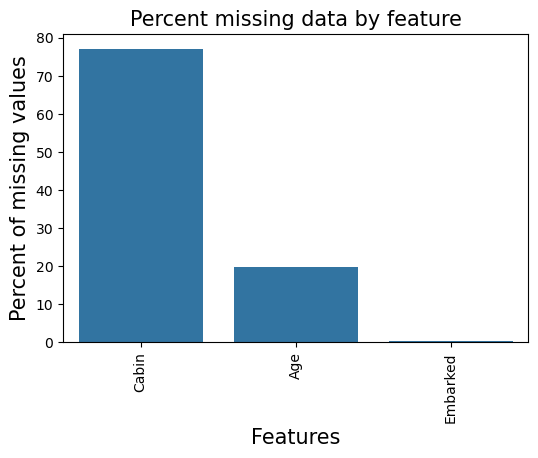

In [28]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na[train_na > 0].sort_values(ascending=False)  # Only keep columns with missing values

f, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [29]:
print("Missing values in Train")
print(train.isnull().sum())

Missing values in Train
Survived          0
Pclass            0
Age             177
Ticket            0
Fare              0
Cabin           687
Embarked          2
FamilyCount       0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
Sex_male          0
dtype: int64


Text(0.5, 1.0, 'Percent missing data by feature')

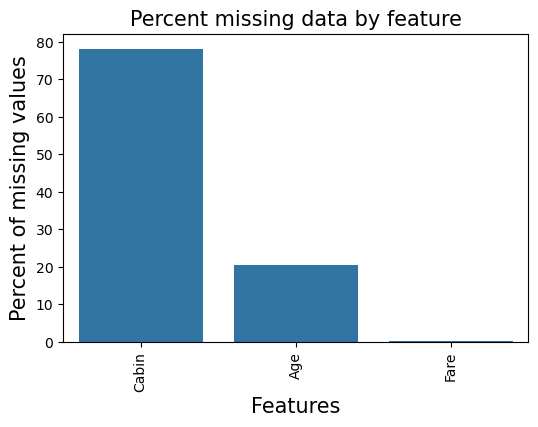

In [32]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na[test_na > 0].sort_values(ascending=False)  # Only keep columns with missing values

f, ax = plt.subplots(figsize=(6, 4))
plt.xticks(rotation=90)
sns.barplot(x=test_na.index, y=test_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [37]:
print("Missing values in Test")
print(test.isnull().sum())

Missing values in Test
Pclass            0
Age              86
Ticket            0
Fare              1
Cabin           327
Embarked          0
FamilyCount       0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
Sex_male          0
dtype: int64


### Drop columns that are unusefull
- `Cabin` has too many null values (687 out of 891 and 327 out of 418) so we will drop it.
- `Ticket` doesn't give us much insights.

In [43]:
columns_to_drop_train = ['Cabin', 'Ticket']
columns_to_drop_test = ['Cabin', 'Ticket']

train = train.drop(columns_to_drop_train, axis = 1)
test = test.drop(columns_to_drop_test, axis = 1)

There are 2 ways we can deal with empty values:
* dropping the rows/columns with empty values.
* imputation - filling the empty values.

Because our DataSet is already small we think it will be best to use the imputation technique for the `Age`, `Embarked` and `Fare`
columns because we dont want to loose valuabe data and make the Dataset even smaller.

### Handle missing values for 'Age'
We will present a heatmap of the features which have a correlation with the `Age`.

<Axes: >

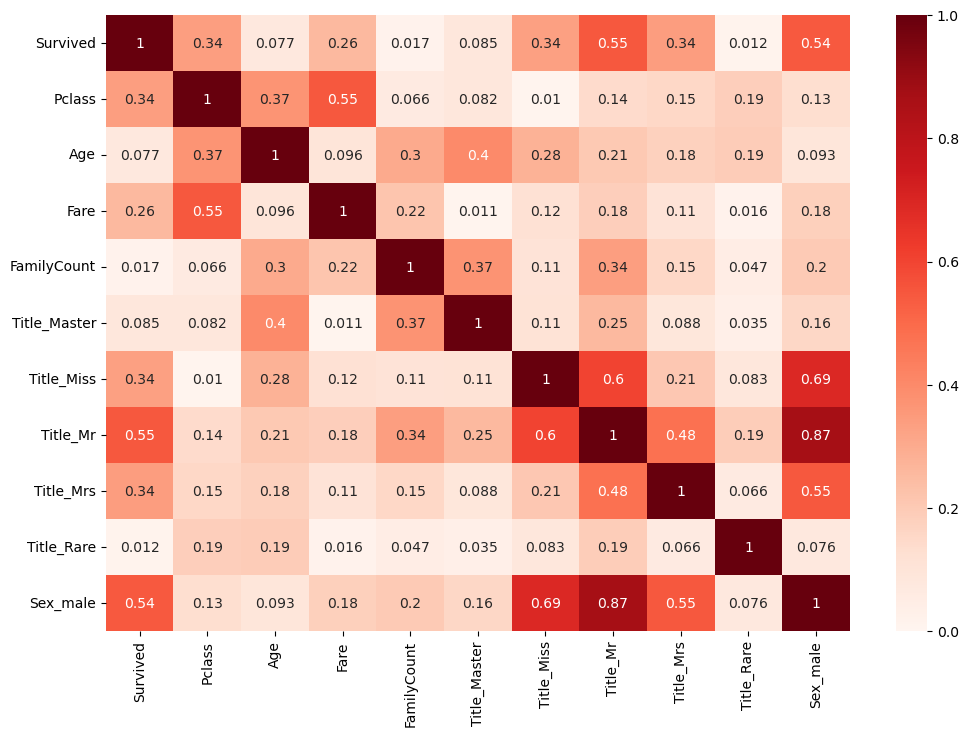

In [50]:
# Heatmap to visualize correlation between Age and other features
numeric_data = train.select_dtypes(include=['number'])
corr_mat = abs(numeric_data.corr())
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)

### Insights From Heatmap
* High correlation between `Age` and `Pclass`.
* High correlation between `Age` and `Titles`.
* we will also add the `Sex_male` that indicates the title's sex.

In [52]:
# create a 'Title' column based on the one-hot encoded title columns to get better results
data_sets = [train, test]

title_columns = ['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
title_mapping = {col: col.split('_')[1] for col in title_columns}

for df in data_sets:
    df['Title'] = df[title_columns].idxmax(axis=1)
    df['Title'] = df['Title'].map(title_mapping)

# grouping by 'Pclass', 'Sex_male', 'Title' to calculate median ages
for df in data_sets:
    median_ages = df.groupby(['Pclass', 'Sex_male', 'Title'])['Age'].transform('median')
    df['Age'] = df['Age'].fillna(median_ages)

train = train.drop('Title', axis=1)
test = test.drop('Title', axis=1)
data_sets = [train, test]
display(train)

,Survived,Pclass,Age,Fare,Embarked,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male
0,0,3,22.0,7.2500,S,2,0,0,1,0,0,1.0
1,1,1,38.0,71.2833,C,2,0,0,0,1,0,0.0
2,1,3,26.0,7.9250,S,1,0,1,0,0,0,0.0
3,1,1,35.0,53.1000,S,2,0,0,0,1,0,0.0
4,0,3,35.0,8.0500,S,1,0,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,S,1,0,0,0,0,1,1.0
887,1,1,19.0,30.0000,S,1,0,1,0,0,0,0.0
888,0,3,18.0,23.4500,S,4,0,1,0,0,0,0.0
889,1,1,26.0,30.0000,C,1,0,0,1,0,0,1.0


### Handle missing values for 'Fare' - Insights From Heatmap
From the heatmap we can see that there is high correlation between `Fare` and `Pclass`.  
We fill the missing `Fare` values by replacing them with the median `Fare` value for each `Pclass` in both the train and test datasets.

In [56]:
for df in data_sets:
    fare_by_pclass = df.groupby('Pclass')['Fare'].transform('median')
    df['Fare'] = df['Fare'].fillna(fare_by_pclass)

data_sets = [train, test]

### Handle missing values for 'Embarked'

**Distribution of 'Embarked' Values:**

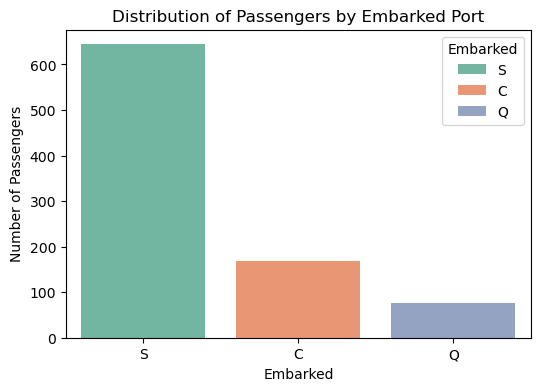

In [60]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Embarked', data=train, hue='Embarked', palette='Set2')
plt.title('Distribution of Passengers by Embarked Port')
plt.xlabel('Embarked')
plt.ylabel('Number of Passengers')
plt.show()

**Relation Between 'Embarked' and 'Pclass':**

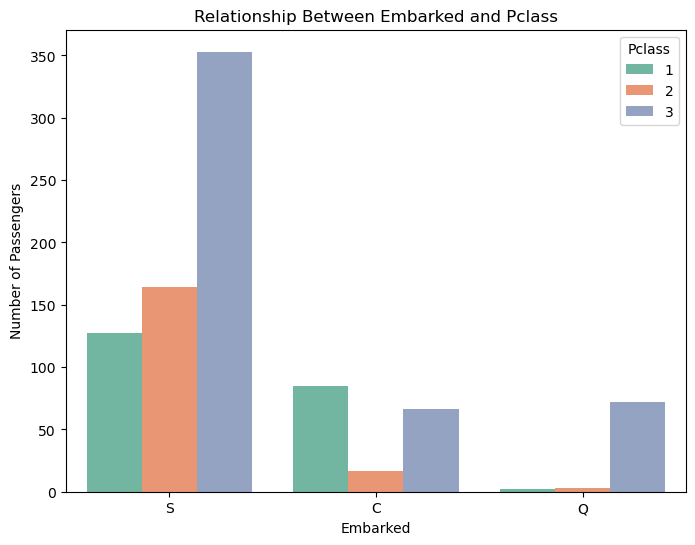

In [64]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Embarked', hue='Pclass', data=train, palette='Set2')
plt.title('Relationship Between Embarked and Pclass')
plt.xlabel('Embarked')
plt.ylabel('Number of Passengers')
plt.legend(title='Pclass', loc='upper right')
plt.show()

### **Insights from the plots**
* majority of passengers embarked at `S`.
* The majority of passengers who embarked at `S` were from `Pclass` 3, with the least from `Pclass` 1. For those who embarked at `C`, most were from `Pclass` 1. Similarly, the majority of passengers who embarked at `Q` were from `Pclass` 3.

From the insights we understand that `Pclass` and `Embarked` are related so we will fill the missing values using this column.

In [66]:
for df in data_sets:
    # Fill missing 'Embarked' values with the mode of 'Embarked' per 'Pclass'
    df['Embarked'] = df.groupby('Pclass')['Embarked'].transform(lambda x: x.mode()[0]).fillna(df['Embarked'])

In [67]:
print("Missing values in Train")
print(test.isnull().sum())

Missing values in Train
Pclass          0
Age             0
Fare            0
Embarked        0
FamilyCount     0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Sex_male        0
dtype: int64


In [68]:
print("Missing values in Test")
print(test.isnull().sum())

Missing values in Test
Pclass          0
Age             0
Fare            0
Embarked        0
FamilyCount     0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rare      0
Sex_male        0
dtype: int64


## Encoding the data  - `Embarked`

---

### One-Hot Encode Categorical Features
Since `Embarked` is a categorical feature with three categories (S, Q, and C), we can encode it using One-Hot Encoding.  
We will do this with the get_dummies() function in Panda.

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Age           891 non-null    float64
 3   Fare          891 non-null    float64
 4   Embarked      891 non-null    object 
 5   FamilyCount   891 non-null    int64  
 6   Title_Master  891 non-null    int32  
 7   Title_Miss    891 non-null    int32  
 8   Title_Mr      891 non-null    int32  
 9   Title_Mrs     891 non-null    int32  
 10  Title_Rare    891 non-null    int32  
 11  Sex_male      891 non-null    float64
dtypes: float64(3), int32(5), int64(3), object(1)
memory usage: 66.3+ KB


In [72]:
# One-hot encode the 'Title' feature
train_title_dummies = pd.get_dummies(train['Embarked'], prefix='Embarked', dtype=int)
test_title_dummies = pd.get_dummies(test['Embarked'], prefix='Embarked', dtype=int)

# Align the columns for train and test datasets
train_title_dummies, test_title_dummies = train_title_dummies.align(test_title_dummies, fill_value=0, axis=1)

# Add the encoded columns to the original DataFrame
train = pd.concat([train, train_title_dummies], axis=1).drop(columns=['Embarked'])
test = pd.concat([test, test_title_dummies], axis=1).drop(columns=['Embarked'])

In [73]:
# Display the updated train dataframe
display(train)

,Survived,Pclass,Age,Fare,FamilyCount,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Sex_male,Embarked_C,Embarked_S
0,0,3,22.0,7.2500,2,0,0,1,0,0,1.0,0,1
1,1,1,38.0,71.2833,2,0,0,0,1,0,0.0,0,1
2,1,3,26.0,7.9250,1,0,1,0,0,0,0.0,0,1
3,1,1,35.0,53.1000,2,0,0,0,1,0,0.0,0,1
4,0,3,35.0,8.0500,1,0,0,1,0,0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,1,0,0,0,0,1,1.0,0,1
887,1,1,19.0,30.0000,1,0,1,0,0,0,0.0,0,1
888,0,3,18.0,23.4500,4,0,1,0,0,0,0.0,0,1
889,1,1,26.0,30.0000,1,0,0,1,0,0,1.0,0,1


## Dealing with outliers  
Outliers are data points that significantly differ from the rest of the data. They can be unusually high or low compared to the other observations in the dataset.  

**Improving model performance** - Outliers can distort the model’s learning process. They can skew the results and lead to inaccurate predictions. By handling outliers, we can help the model learn more meaningful patterns from the data.

---

We use scatter plots to visualize the relationship between the three feature- `Age`, `Fare` and `FamilyCount`, and the target variable, `Survived`.  
The rest of the features have binary values so we didn't choose to focuse on them.  

Outliers are often represented as data points that are far away from the general trend or cluster of data points.

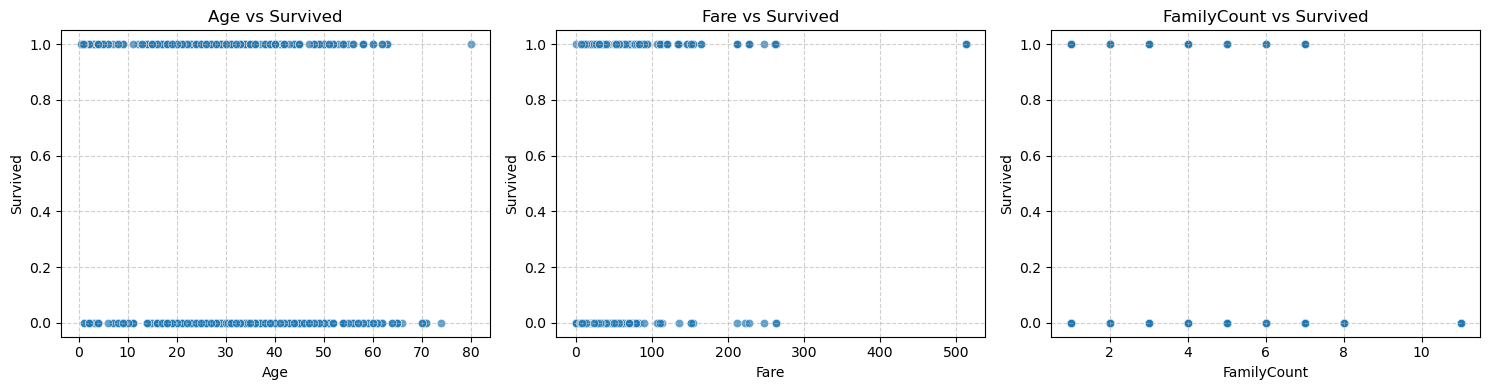

In [78]:
def scatter_plot_features_vs_survived(df, features=['Age', 'Fare', 'FamilyCount'], target='Survived', cols=3):
    rows = (len(features) + cols - 1) // cols  # Calculate required rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten to simplify indexing
    
    for i, feature in enumerate(features):
        # Scatter plot for the feature vs target
        sns.scatterplot(data=df, x=feature, y=target, alpha=0.7, ax=axes[i])
        axes[i].set_title(f'{feature} vs {target}', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel(target, fontsize=10)
        axes[i].grid(True, linestyle='--', alpha=0.6)
        
        # Highlight potential outliers (values outside 1.5 * IQR)
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Adjust layout for readability
    plt.show()

# Call the function for specific features
scatter_plot_features_vs_survived(train, features=['Age', 'Fare', 'FamilyCount'], cols=3)


In [80]:
train = train.drop(train[train['Age'] > 70].index)
train = train.drop(train[train['Fare'] >= 300].index)
train = train.drop(train[train['FamilyCount'] >= 9].index)

# Assignment 3  
---

## Data Classification  
  
In order to classify the data we will compare `LDA`, `NBC` and `KNN`, and choose the best model for our project.  
For `KNN` and `LDA` we will check all the hyper parameters to find the best combination, and use feature selection methods to see what features are the best for each model.  
We chose `forward` feature selection for this project because it's efficient and works well with the small Titanic dataset. It adds features one by one based on their importance, helping us find the key predictors of survival while keeping the process simple and easy to understand.

---


=== Training KNN ===
Best Parameters for KNN (n_features_to_select=3): {'bootstrap': True, 'bootstrap_features': False, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Selected Features: ['FamilyCount', 'Title_Master', 'Sex_male']
OOB Score: 0.8288

=== Training LDA ===
Best Parameters for LDA (n_features_to_select=5): {'bootstrap': True, 'bootstrap_features': False, 'estimator__covariance_estimator': None, 'estimator__n_components': None, 'estimator__priors': None, 'estimator__shrinkage': None, 'estimator__solver': 'lsqr', 'estimator__store_covariance': False, 'estimator__tol': 0.0001, 'estimator': LinearDiscrimina

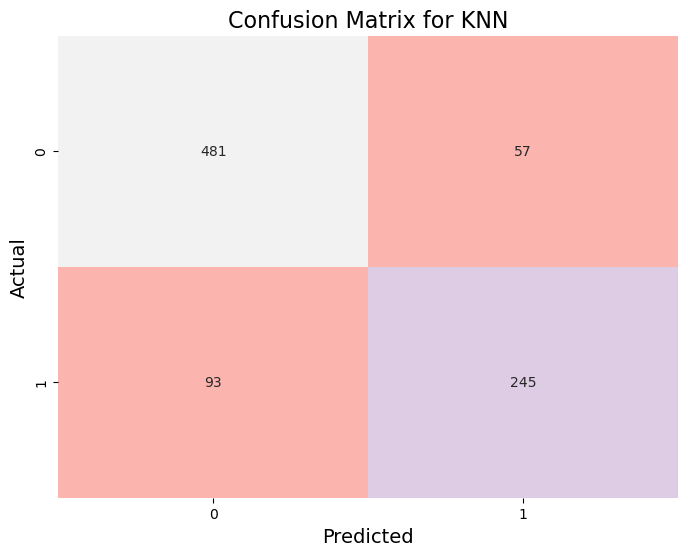

Precision: 0.8113
Recall: 0.7249
F1 Score: 0.7656


In [83]:
# Step 1: Use preprocessed data
X = train.drop(columns=['Survived'])  # Features (already preprocessed)
y = train['Survived']  # Target

# Add small constant to prevent zero variance
epsilon = 1e-10
X = X + epsilon

def create_pipeline(estimator, feature_selection_type='forward', n_features_to_select=5):
    """
    Creates a pipeline with a feature selection step and a classifier.
    
    Parameters:
        estimator: The machine learning estimator (e.g., KNN, LDA, NBC).
        feature_selection_type: The type of feature selection ('forward' or 'backward').
        n_features_to_select: The number of features to select (e.g., 3, 5, 7).
    
    Returns:
        A pipeline with the specified feature selection and estimator.
    """
    if feature_selection_type == 'forward':
        feature_selection = SequentialFeatureSelector(
            estimator, 
            direction='forward',
            n_features_to_select=n_features_to_select,
            n_jobs=-1
        )
    elif feature_selection_type == 'backward':
        feature_selection = SequentialFeatureSelector(
            estimator,
            direction='backward',
            n_features_to_select=n_features_to_select,
            n_jobs=-1
        )
    else:
        raise ValueError("Unknown feature selection type: choose 'forward' or 'backward'")

    # Create the pipeline with feature selection and the estimator
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', feature_selection),
        ('classifier', BaggingClassifier(
            estimator=estimator,
            n_estimators=20,
            bootstrap=True,
            oob_score=True,  # Enable OOB validation
            random_state=42))
    ])
    return pipeline

# Modified parameter grids
models = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(solver='lsqr'),  # Changed default solver
    'NBC': GaussianNB(var_smoothing=1e-8)  # Added var_smoothing parameter
}

param_grids = {
    'KNN': {
        'feature_selection__n_features_to_select': [3, 5, 7],
        'classifier__estimator__n_neighbors': [3, 5, 7],
        'classifier__estimator__weights': ['uniform', 'distance']
    },
    'LDA': {
        'feature_selection__n_features_to_select': [3, 5, 7],
        'classifier__estimator__solver': ['lsqr'],  # Removed problematic solvers
        'classifier__estimator__shrinkage': [0.1, 0.5, 0.9]  # Modified shrinkage values
    },
    'NBC': {
        'feature_selection__n_features_to_select': [3, 5, 7],
        'classifier__estimator__var_smoothing': [1e-8, 1e-7, 1e-6]  # Added var_smoothing parameter
    }
}

# Train and evaluate models with error handling
best_models = {}
best_oob_scores = {}

for model_name, base_model in models.items():
    print(f"\n=== Training {model_name} ===")
    
    best_oob_score = -np.inf
    best_pipeline = None
    best_selected_features = []

    try:
        # For each parameter grid, loop over the `n_features_to_select` values
        for n_features in param_grids[model_name]['feature_selection__n_features_to_select']:
            # Create pipeline with the correct number of features to select
            pipeline = create_pipeline(base_model, feature_selection_type='forward', n_features_to_select=n_features)
            
            # Fit the model without GridSearchCV (no CV here, we're using OOB for validation)
            pipeline.fit(X, y)
            
            # Get OOB score (validation score from the bootstrap)
            oob_score = pipeline.named_steps['classifier'].oob_score_

            # Track the best configuration
            if oob_score > best_oob_score:
                best_oob_score = oob_score
                best_pipeline = pipeline
                
                # Get selected features
                feature_selector = pipeline.named_steps['feature_selection']
                selected_features_mask = feature_selector.support_
                best_selected_features = X.columns[selected_features_mask].tolist()
                best_n_features = len(best_selected_features)

        
        # Store the best model with its OOB score
        best_models[model_name] = best_pipeline
        best_oob_scores[model_name] = best_oob_score
        
        # Print the best configuration for the model
        print(f"Best Parameters for {model_name} (n_features_to_select={best_n_features}): {best_pipeline.named_steps['classifier'].get_params()}")
        print(f"Selected Features: {best_selected_features}")
        print(f"OOB Score: {best_oob_score:.4f}")

    except Exception as e:
        print(f"Error during training {model_name}: {str(e)}")
        continue

# Evaluate the best KNN model
def evaluate_knn_model(model, X, y, model_name):
    try:
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y, y_pred))
        
        # Display confusion matrix
        oob_predictions = model.named_steps['classifier'].oob_decision_function_.argmax(axis=1)
        cm = confusion_matrix(y, oob_predictions)
        
        # Set pastel colors for the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Pastel1',  # Pastel color map
            cbar=False,
            xticklabels=model.named_steps['classifier'].classes_,
            yticklabels=model.named_steps['classifier'].classes_,
        )
        plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
        plt.xlabel('Predicted', fontsize=14)
        plt.ylabel('Actual', fontsize=14)
        plt.show()
        
        # Calculate and display KPIs
        precision = precision_score(y, oob_predictions)
        recall = recall_score(y, oob_predictions)
        f1 = f1_score(y, oob_predictions)
        
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")

# Evaluate the best KNN model
evaluate_knn_model(best_models['KNN'], X, y, 'KNN')

# Plot training vs. validation errors and accuracies for KNN
train_errors = []
oob_errors = []
train_accuracies = []
oob_accuracies = []

for n_features in param_grids['KNN']['feature_selection__n_features_to_select']:
    pipeline = create_pipeline(models['KNN'], feature_selection_type='forward', n_features_to_select=n_features)
    pipeline.fit(X, y)
    
    train_predictions = pipeline.predict(X)
    oob_predictions = pipeline.named_steps['classifier'].oob_decision_function_.argmax(axis=1)
    
    train_errors.append(1 - accuracy_score(y, train_predictions))
    oob_errors.append(1 - accuracy_score(y, oob_predictions))
    train_accuracies.append(accuracy_score(y, train_predictions))
    oob_accuracies.append(accuracy_score(y, oob_predictions))
    

The output shows the results of training three different models (`KNN`, `LDA`, and `NBC`) on the Titanic dataset with feature selection.   
`KNN` achieved the accuracy 82.88%, with the selected features being FamilyCount, Title_Master, and Sex_male. `LDA` and `NBC` also performed well with accuracies of 82.99% and 80.82%, respectively. However, we chose to work with `KNN` over `LDA` and `NBC` because our data isn't normally distributed and some of the features are highly correlated, which makes `KNN` a more robust choice. KNN is non-parametric and doesn't assume any specific distribution for the data, unlike `LDA`, which assumes normality, or `NBC`, which assumes independence between features.

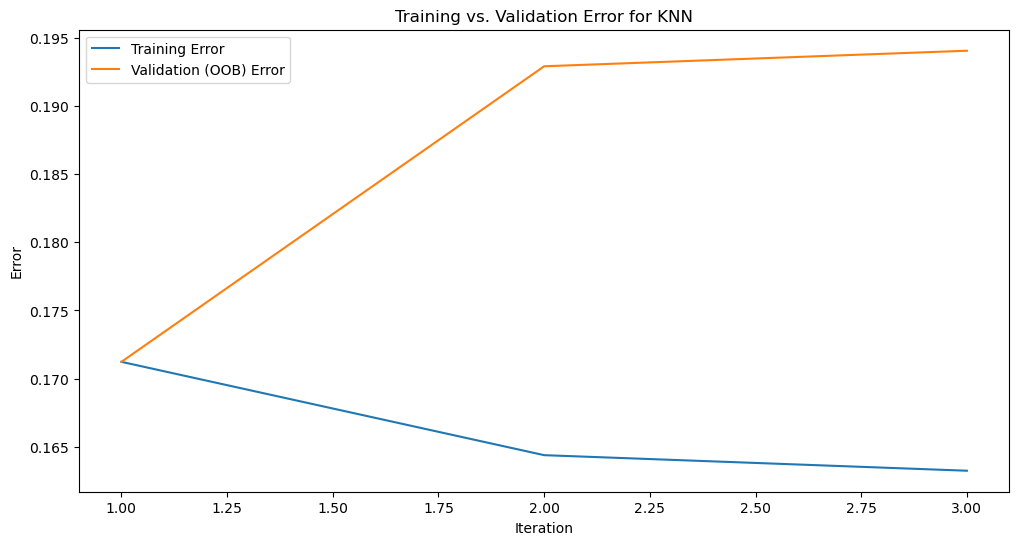

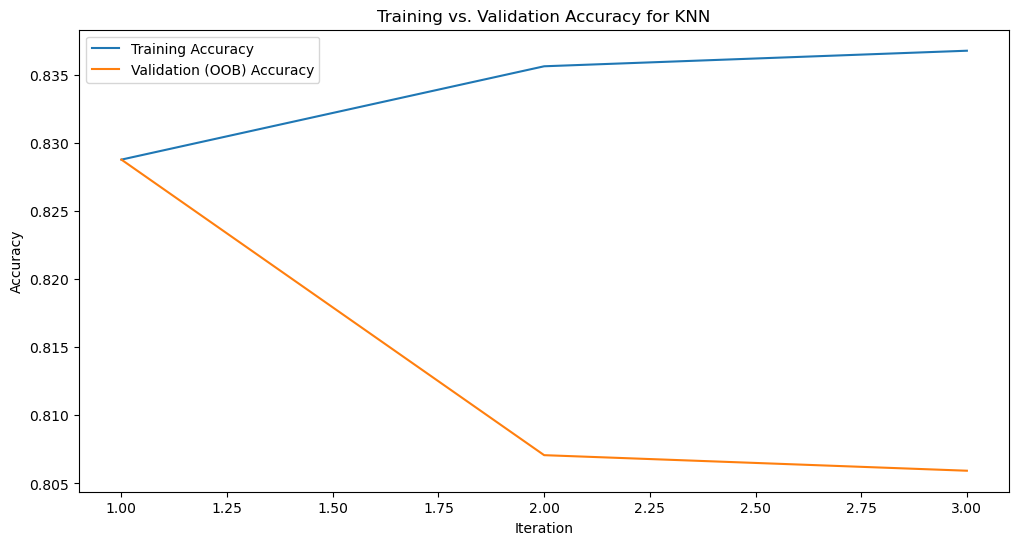

In [86]:
# Plot errors
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label='Training Error')
plt.plot(range(1, len(oob_errors) + 1), oob_errors, label='Validation (OOB) Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.title('Training vs. Validation Error for KNN')
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(oob_accuracies) + 1), oob_accuracies, label='Validation (OOB) Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy for KNN')
plt.show()

The KNN model's training error improves with more selected features (3, 5, 7), while the validation error slightly worsens, suggesting overfitting. Training accuracy increases, but validation accuracy declines, reinforcing this trend. Feature selection impacts the balance between underfitting and overfitting.

## Exporting model results
Now we run the model on the test and get the results into a csv file.  
 
---

In [89]:
# Get the best KNN model from your previous training
best_knn = best_models['KNN']

# Make predictions on the test set
# The pipeline will automatically handle feature selection and scaling
X_test = test.drop(columns=['Survived'] if 'Survived' in test.columns else [])

# Add small constant to prevent zero variance (same as training)
epsilon = 1e-10
X_test = X_test + epsilon

# Make predictions
y_pred_test = best_knn.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_ID,
    'Survived': y_pred_test
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Display first few predictions
print("\nFirst few predictions:")
print(submission.head())

# Display value counts of predictions
print("\nPrediction distribution:")
print(submission['Survived'].value_counts(normalize=True))


First few predictions:
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

Prediction distribution:
Survived
0    0.619617
1    0.380383
Name: proportion, dtype: float64


## **Submission in Kaggle**  
We will now apply this trained model to make predictions on the test set and submit the results in the required format.  

---

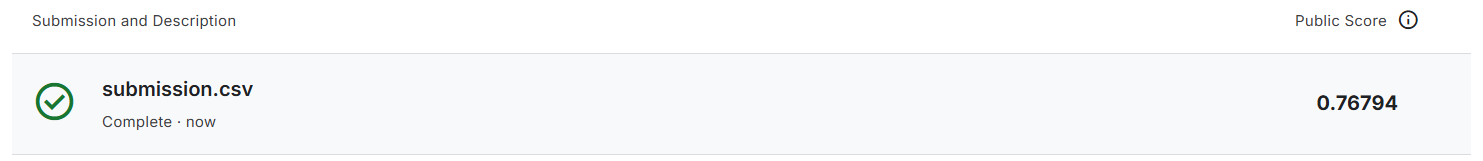

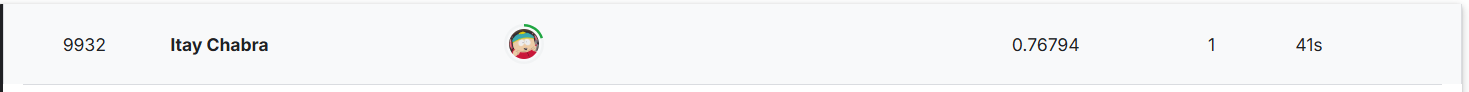

## **Summary**   
---

In this project, we analyzed the Titanic dataset to predict passenger survival using various machine learning models, including K-Nearest Neighbors (KNN), Linear Discriminant Analysis (LDA), and Naive Bayes Classifier (NBC). The process involved data preprocessing (handling missing values and adding a small constant to prevent zero variance), feature selection (using forward selection), and model training with bootstrap bagging.  

We evaluated the models using Out-Of-Bag (OOB) validation to estimate their performance. Key performance metrics such as accuracy, precision, recall, and F1 score were calculated. The best-performing model, KNN, was further analyzed by displaying a confusion matrix and plotting training vs.   validation errors and accuracies.

Finally, the best KNN model was tested on the test dataset using the selected features, and the results were saved into a CSV file.  

**References:**  
- Lab notebooks
- Chat GPT